In [1]:
import pickle

In [2]:
# conll 2003
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

--2024-05-15 02:33:14--  https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4757208 (4.5M) [application/octet-stream]
Saving to: ‘ner_train.pkl’

ner_train.pkl       100%[===================>]   4.54M  --.-KB/s    in 0.09s   

2024-05-15 02:33:14 (47.8 MB/s) - ‘ner_train.pkl’ saved [4757208/4757208]

--2024-05-15 02:33:14--  https://lazyprogrammer.me/course_files/nlp/ner_test.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201978 (1.1M) [application/octet-stream]
Saving to: ‘ner_test.pkl’

ner_test.pkl        100%[===========

In [3]:
with open('ner_train.pkl', 'rb') as f:
  corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
  corpus_test = pickle.load(f)

In [4]:
corpus_train

[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('The', 'O'),
  ('European', 'B-ORG'),
  ('Commission', 'I-ORG'),
  ('said', 'O'),
  ('on', 'O'),
  ('Thursday', 'O'),
  ('it', 'O'),
  ('disagreed', 'O'),
  ('with', 'O'),
  ('German', 'B-MISC'),
  ('advice', 'O'),
  ('to', 'O'),
  ('consumers', 'O'),
  ('to', 'O'),
  ('shun', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('until', 'O'),
  ('scientists', 'O'),
  ('determine', 'O'),
  ('whether', 'O'),
  ('mad', 'O'),
  ('cow', 'O'),
  ('disease', 'O'),
  ('can', 'O'),
  ('be', 'O'),
  ('transmitted', 'O'),
  ('to', 'O'),
  ('sheep', 'O'),
  ('.', 'O')],
 [('Germany', 'B-LOC'),
  ("'s", 'O'),
  ('representative', 'O'),
  ('to', 'O'),
  ('the', 'O'),
  ('European', 'B-ORG'),
  ('Union', 'I-ORG'),
  ("'s", 'O'),
  ('veterinary', 'O'),
  ('committee', 'O'),
  ('Werner', 'B-PER'),
  ('Zwingmann', 'I-PER'),
  ('said

In [6]:
len(corpus_train)

12733

In [7]:
train_inputs = []
train_targets = []

for sentence_tag_pairs in corpus_train:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  train_inputs.append(tokens)
  train_targets.append(target)

In [8]:
test_inputs = []
test_targets = []

for sentence_tag_pairs in corpus_test:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  test_inputs.append(tokens)
  test_targets.append(target)

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [11]:
# Convert sentences to sequences

MAX_VOCAB_SIZE = None

# capitalization might be useful - test it
should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK',
)
# otherwise unknown tokens will be removed and len(input) != len(target)
# input words and target words will not be aligned!

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [12]:
# get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 23299 unique tokens.


In [13]:
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [14]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [15]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [16]:
all_train_targets == all_test_targets

True

In [17]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [18]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))
T

113

In [19]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (12733, 113)


In [20]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (2970, 113)


In [21]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

Shape of train targets tensor: (12733, 113)


In [22]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of test targets tensor: (2970, 113)


In [23]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

10

In [24]:
# Create the model

# We get to choose embedding dimensionality
D = 32

i = Input(shape=(T,))
# mask_zero=True way slower on GPU than CPU!
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [25]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

# NOTE: you "could" speed this up by creating a custom loss, since Tensorflow's
# implementation of mask_zero currently sucks, but it's sufficiently advanced...
# In my experiments, CPU is faster than GPU in all cases, and CPU for custom
# loss is faster than CPU for mask_zero

# > 300-400s per epoch on CPU
# > 30 MINUTES per epoch on GPU
print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5
398/398 [==============================] - 77s 171ms/step - loss: 0.7188 - accuracy: 0.8381 - val_loss: 0.4889 - val_accuracy: 0.8635
Epoch 2/5
398/398 [==============================] - 55s 138ms/step - loss: 0.3066 - accuracy: 0.9017 - val_loss: 0.3280 - val_accuracy: 0.9090
Epoch 3/5
398/398 [==============================] - 56s 141ms/step - loss: 0.1719 - accuracy: 0.9506 - val_loss: 0.2331 - val_accuracy: 0.9421
Epoch 4/5
398/398 [==============================] - 57s 144ms/step - loss: 0.0836 - accuracy: 0.9801 - val_loss: 0.1925 - val_accuracy: 0.9532
Epoch 5/5
398/398 [==============================] - 55s 139ms/step - loss: 0.0458 - accuracy: 0.9900 - val_loss: 0.1811 - val_accuracy: 0.9521


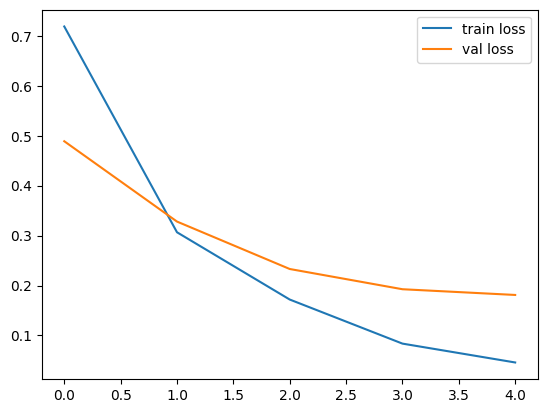

In [26]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

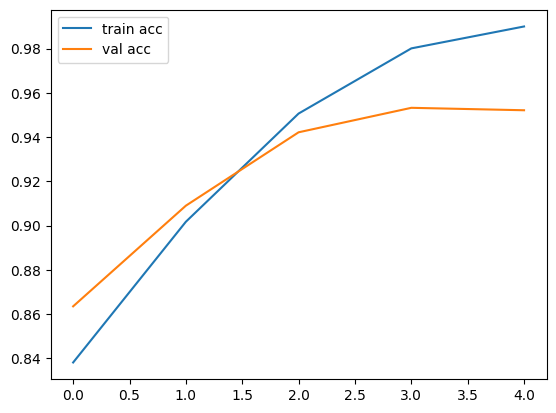

In [27]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [28]:
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

In [29]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

398/398 [==============================] - 13s 24ms/step


In [30]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

93/93 [==============================] - 4s 40ms/step


In [31]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9938364879910927
Test acc: 0.9521026428163804
Train f1: 0.9562368125215115
Test f1: 0.7980114077048471


In [32]:
### Baseline model: map word to tag
from collections import Counter

# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [33]:
token2tags = {k: [] for k, v in word2idx.items()}

# remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if should_lowercase:
      token = token.lower()
    if token in token2tags:
      token2tags[token].append(tag)

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [34]:
# compute accuracy

train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [35]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [36]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.974769365357086
Test acc: 0.8881673455733318
Train f1: 0.8549353965547479
Test f1: 0.6381158268902334


In [ ]:
# Conclusion: mistake may arise from "trusting the library too much", assuming you can just use the
# Tokenizer() with default values and Embedding() with default values, and not thinking about what they actually do.

# i.e. it's important to THINK, not just "use libraries".